<div style="text-align:left">

## Sentiment Analysis on Amazon Fine Food Reviews

#### Mt. SAC CISB 62 Final Project - Fall 2023

#### Russell Luna

## https://github.com/rmoon64/CISB62_Final/

</div>

## Introduction / Summary:
### The 'Amazon Fine Food Reviews' from Kaggle is a complete dataset that has about 560,000 reviews, which we trim down to 50,000 reviews. The goal of the project is to recommend new products to someone who does reviews often (Chris), using RNN to perform sentimental analysis using only Amazon reviews as the model.

### This project utilized various deep learning techniques. The main tools used were RNN, TensorFlow V1, and hyperparameter tuning. First, I utilized a trimmed-down version of the data set with 50,000 reviews. Then, I used Matplotlib to plot the visualizations of important data, for example, the top 10 products with the most reviewers and the percentage of positive and negative reviews made by Chris. I then prepared the RNN with the LSTM model. This model was then fitted using six epochs and a batch size of twenty. This proved to be very beneficial, as the accuracy was extremely high at 0.9953 with a quite low loss of 0.0160. Next, I cleaned the data and defined the parameters and placeholders. Lastly, I got the scores and recommendations for Chris.

https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
import tensorflow as tf
import seaborn as sns
import re
import pandas as pd
import numpy as np
import keras
import datetime

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from string import punctuation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Import dataset
df = pd.read_csv('Reviews.csv')

In [4]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04
mean,25000.500000,1.603360,2.060260,4.145840,1.295198e+09
std,14433.901067,5.620771,6.216044,1.325596,4.734622e+07
min,1.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,12500.750000,0.000000,0.000000,4.000000,1.269648e+09
50%,25000.500000,0.000000,1.000000,5.000000,1.309133e+09
75%,37500.250000,2.000000,2.000000,5.000000,1.331078e+09
max,50000.000000,398.000000,401.000000,5.000000,1.351210e+09


In [5]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49995 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49998 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB


In [7]:
print(df.shape)

(50000, 10)


In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df["Text"][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [10]:
#Grabbing the columns that we need
df_reviews = df[['ProductId','ProfileName','Score','Text','HelpfulnessNumerator','HelpfulnessDenominator']]

In [11]:
#Loading the top 10 reviewers with the most reviews.
df.pivot_table(columns=['ProfileName'], aggfunc='size').sort_values(ascending=False).head(10)

ProfileName
Gary Peterson                             44
C. F. Hill "CFH"                          39
O. Brown "Ms. O. Khannah-Brown"           35
c2                                        35
Gunner                                    31
Chris                                     31
Rebecca of Amazon "The Rebecca Review"    29
Laura                                     24
Amanda                                    24
Mike                                      24
dtype: int64

In [12]:
popular = df[['ProductId','ProfileName']].groupby('ProductId').count().sort_values(['ProfileName'],ascending=False).reset_index()

In [13]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Visuals: matplotlib and seaborn

In [14]:
top_10_popular = popular.head(10) # Select the top 10 products with the most reviewers

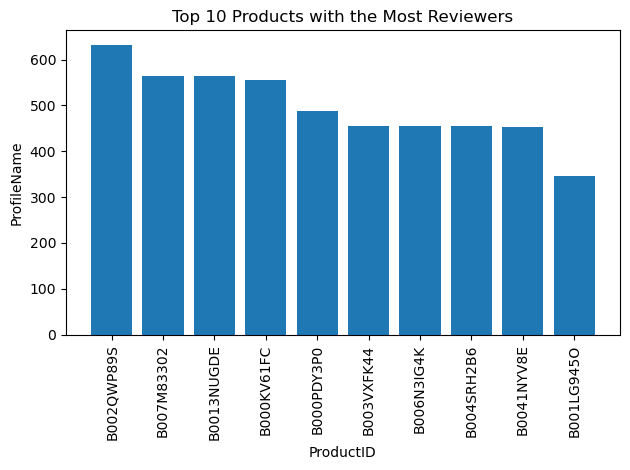

In [15]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.bar(top_10_popular['ProductId'], top_10_popular['ProfileName'])
axs.set_xlabel('ProductID')
axs.set_ylabel('ProfileName')
axs.set_title('Top 10 Products with the Most Reviewers')
plt.xticks(rotation=90) # Rotate x-axis labels for better visibility
plt.show()

In [16]:
df_reviews[df_reviews['ProfileName']=='Chris']

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator
151,B00374XSVY,Chris,5,Works with chicken fish beef or pork. Fast eas...,0,0
637,B000G6RYNE,Chris,4,"This kettle chips taste ""Good , Crispy & Crunc...",0,0
729,B008BEGP9W,Chris,4,I really like the pineapple shortcakes sold he...,0,0
1006,B002XG21MO,Chris,5,These are just like the animal crackers we eat...,0,0
3142,B000FDKQCY,Chris,5,This product is as good as any that I have eve...,0,0
5301,B003OJLCXI,Chris,4,"I really like this tea, but my husband smelled...",1,1
5826,B000633O2C,Chris,5,I want to give my cats as much variety as poss...,1,2
7424,B005LMLXN0,Chris,5,"As a tea-junkie, Runa's traditional guayusa of...",1,1
7653,B000TRFGGM,Chris,4,I opened the carton and the plant looked like ...,0,0
7812,B00474H936,Chris,4,"I have tried almost every kind of ""fake meat"" ...",0,0


<h3>Plotting Chris' percentage of positive views vs negative reviews</h3>

In [17]:
df_chris = df_reviews[df_reviews['ProfileName']=='Chris']

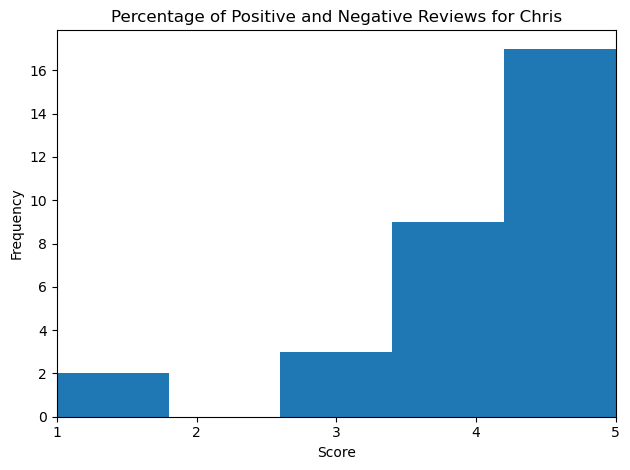

In [18]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_chris['Score'], bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
axs.set_title('Percentage of Positive and Negative Reviews for Chris')
axs.set_xlabel('Score')
axs.set_ylabel('Frequency')
plt.show()

<h3>Plotting the total reviews</h3>

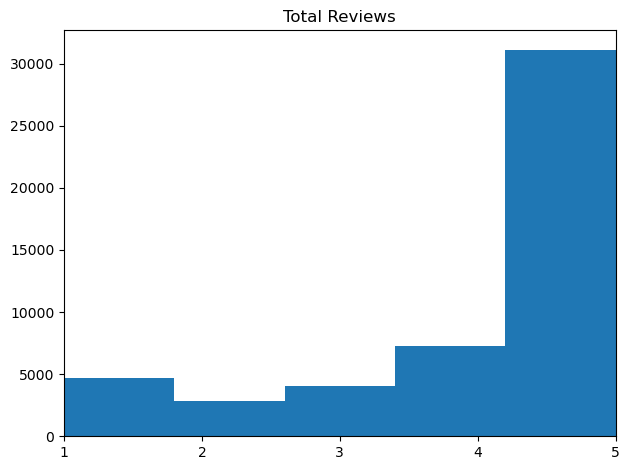

In [19]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['Score'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.title('Total Reviews')
plt.show()

<h3>Histogram of helpfulness rating</h3>

In [20]:
df_reviews['Percent'] = (df_reviews['HelpfulnessNumerator'] / df_reviews['HelpfulnessDenominator'])*100
df_reviews['Percent'].fillna(0,inplace=True)

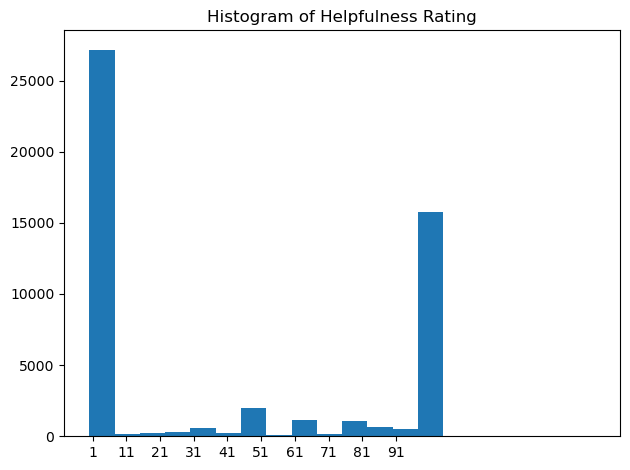

In [21]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['Percent'],bins=20)
plt.xticks(np.arange(1, 100, 10))
plt.title('Histogram of Helpfulness Rating')
plt.show()

In [22]:
df_reviews['Polarity_Rating'] = df_reviews['Score'].apply(lambda x: 'Positive' if x > 3 else 'Negative')

<Axes: xlabel='Polarity_Rating', ylabel='count'>

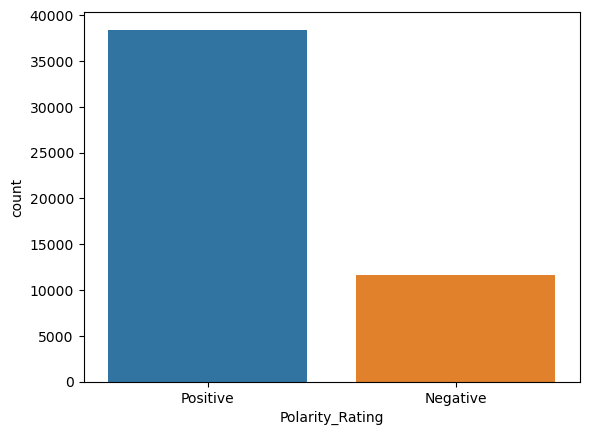

In [23]:
sns.countplot(data = df_reviews, x= 'Polarity_Rating')

In [24]:
df_reviews[df_reviews['Polarity_Rating'] == 'Negative'].shape[0]

11582

In [25]:
data_Positive = df_reviews[df_reviews['Polarity_Rating'] == 'Positive'][0:12500]
data_Negative = df_reviews[df_reviews['Polarity_Rating'] == 'Negative']

data_Negative_over = data_Negative.sample(20000, replace=True)
df_balance_reviews = pd.concat([data_Positive, data_Negative_over], axis=0)

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
#Setting the stop words
english_stops = set(stopwords.words('english'))

In [28]:
df = df_balance_reviews
x_data = df['Text']       # Reviews/Input
y_data = df['Polarity_Rating']    # Sentiment/Output

# PRE-PROCESS REVIEW
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

# ENCODE SENTIMENT -> 0 & 1
y_data = y_data.replace('Positive', 1)
### simmilarly for y_data
y_data = y_data.replace('Negative', 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=101)

In [30]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [31]:
max_length = get_max_length(X_train)
print(max_length)

48


In [32]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 
token.fit_on_texts(X_train)
x_train = token.texts_to_sequences(X_train)
x_test = token.texts_to_sequences(X_test)

### this is the code to add the pad to x_train
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

############# add pad to x_test   ########################### 
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

In [33]:
# ARCHITECTURE
EMBED_DIM = 3200
LSTM_OUT = 64

#### add the model here:
model = Sequential()

#model.add(Embedding(input_dim=max_length, output_dim=LSTM_OUT,input_length=max_length))
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(units=1, activation='sigmoid'))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Adding a Checkpoint to save the model.
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 3200)          84083200  
                                                                 
 lstm (LSTM)                 (None, 64)                835840    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 84919105 (323.94 MB)
Trainable params: 84919105 (323.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Fit the model
history = model.fit(x_train, y_train, epochs=6, batch_size=20, callbacks= [checkpoint],validation_data=(x_test, y_test))

Epoch 1/6


1300/1300 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.7871
Epoch 1: accuracy improved from -inf to 0.78708, saving model to models\LSTM.h5
1300/1300 [==============================] - 722s 550ms/step - loss: 0.4488 - accuracy: 0.7871 - val_loss: 0.3165 - val_accuracy: 0.8706
Epoch 2/6
1300/1300 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9298
Epoch 2: accuracy improved from 0.78708 to 0.92981, saving model to models\LSTM.h5
1300/1300 [==============================] - 707s 544ms/step - loss: 0.1882 - accuracy: 0.9298 - val_loss: 0.2889 - val_accuracy: 0.8880
Epoch 3/6
1300/1300 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9716
Epoch 3: accuracy improved from 0.92981 to 0.97158, saving model to models\LSTM.h5
1300/1300 [==============================] - 834s 641ms/step - loss: 0.0871 - accuracy: 0.9716 - val_loss: 0.3048 - val_accuracy: 0.9006
Epoch 4/6
1300/1300 [=============================

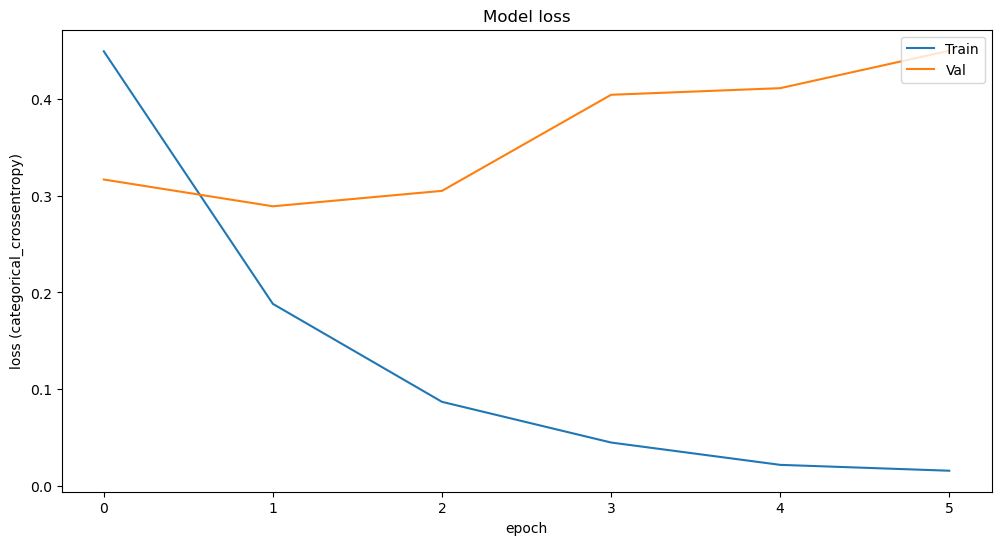

In [36]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

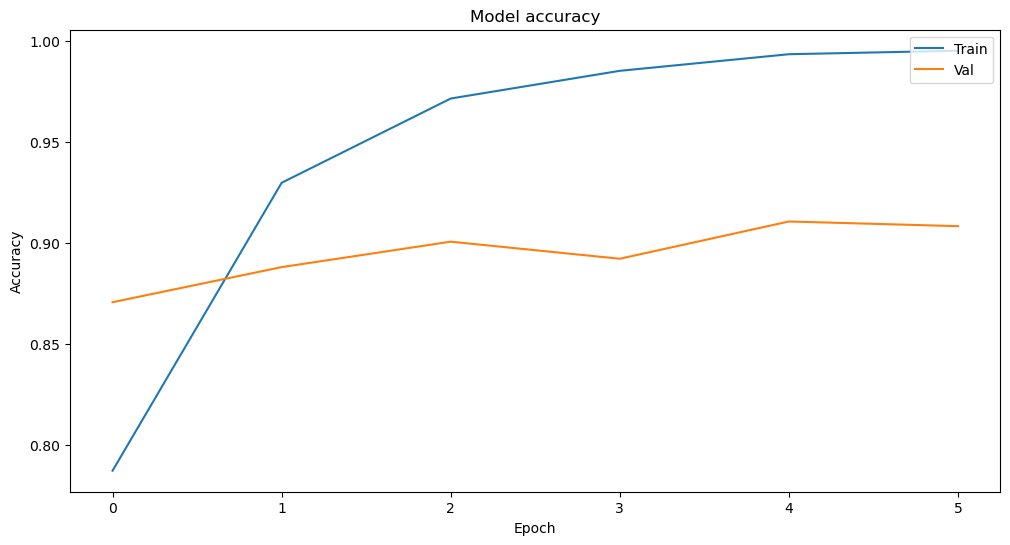

In [37]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [38]:
#I grab a random review from the dataframe
value = 200
df_reviews.iloc[value]

ProductId                                                        B0028C44Z0
ProfileName                                                             Lou
Score                                                                     2
Text                      Even with small containers, they don't fill th...
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Percent                                                                 0.0
Polarity_Rating                                                    Negative
Name: 200, dtype: object

In [39]:
df_reviews.iloc[value]['Text']

"Even with small containers, they don't fill them up.  These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares?  Or how about the cereal ploy, they were filled at the factory but settled in transport.<br />Can manufacturers be honest in their dealings?"

In [40]:
review = df_reviews.iloc[value]['Text']

regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

In [41]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')

In [42]:
result = model.predict(tokenize_words)

if result >= .50:
    print('Postive')
else:
    print('Negative')

1/1 [==============================] - 1s 631ms/step
Negative


In [43]:
#Making an Unique Numeric ID for all the users
df_reviews['UserID'] = pd.factorize(df_reviews['ProfileName'])[0] + 1

In [44]:
df_reviews[df_reviews['UserID'] == 151].head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
151,B00374XSVY,Chris,5,Works with chicken fish beef or pork. Fast eas...,0,0,0.0,Positive,151
637,B000G6RYNE,Chris,4,"This kettle chips taste ""Good , Crispy & Crunc...",0,0,0.0,Positive,151
729,B008BEGP9W,Chris,4,I really like the pineapple shortcakes sold he...,0,0,0.0,Positive,151
1006,B002XG21MO,Chris,5,These are just like the animal crackers we eat...,0,0,0.0,Positive,151
3142,B000FDKQCY,Chris,5,This product is as good as any that I have eve...,0,0,0.0,Positive,151


In [45]:
#I had to clean the data some more, some review went back and review the same item mulitple times as a follow up.
cleaned = df_reviews.drop_duplicates(subset=['ProductId', 'UserID'], keep='last')

print('Removed Dulipcated, Total Reviews {}'.format(cleaned.shape[0]))
print('Total Reviews {}'.format(df_reviews.shape[0]))

Removed Dulipcated, Total Reviews 49283
Total Reviews 50000


In [46]:
cleaned.head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
0,B001E4KFG0,delmartian,5,I have bought several of the Vitality canned d...,1,1,100.0,Positive,1
1,B00813GRG4,dll pa,1,Product arrived labeled as Jumbo Salted Peanut...,0,0,0.0,Negative,2
2,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,This is a confection that has been around a fe...,1,1,100.0,Positive,3
3,B000UA0QIQ,Karl,2,If you are looking for the secret ingredient i...,3,3,100.0,Negative,4
4,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,Great taffy at a great price. There was a wid...,0,0,0.0,Positive,5


In [47]:
user_rating_df = cleaned.pivot(index='UserID', columns='ProductId', values='Score')

In [48]:
user_rating_df.head(5)

ProductId,2734888454,B00002NCJC,B00002Z754,B00005V3DC,B000084DVR,B000084E1U,B000084EK4,B000084EK5,B000084EK6,B000084EK7,...,B009DR3GYI,B009GUDRDM,B009HINRX8,B009KAQZ9G,B009KOHGEK,B009KP6HBM,B009NTCO4O,B009O7B1I0,B009UOFU20,B009WSNWC4
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
tf.compat.v1.disable_eager_execution()

In [50]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.compat.v1.placeholder("float", [visibleUnits])
hb = tf.compat.v1.placeholder("float", [hiddenUnits])
W = tf.compat.v1.placeholder("float", [visibleUnits, hiddenUnits])

# Process phase 1 of a RBM, use v0, _h0, h0
v0 = tf.compat.v1.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(input=_h0))))

#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(input=_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Learning rate
alpha = 1.0

w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

CD = (w_pos_grad - w_neg_grad) / tf.compat.v1.to_float(tf.shape(v0)[0])

update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

err = v0 - v1
err_sum = tf.reduce_mean(err * err)

#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


# Using a for loop, Run the model, with 10 epochs, batchsize = 100, and errors = []
epochs = 10
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])

Instructions for updating:
Use `tf.cast` instead.
0.0025635296
0.0013016531
0.0009061099
0.0007227106
0.00061612227
0.00055364566
0.00051163853
0.00048007743
0.00045839624
0.0004471017


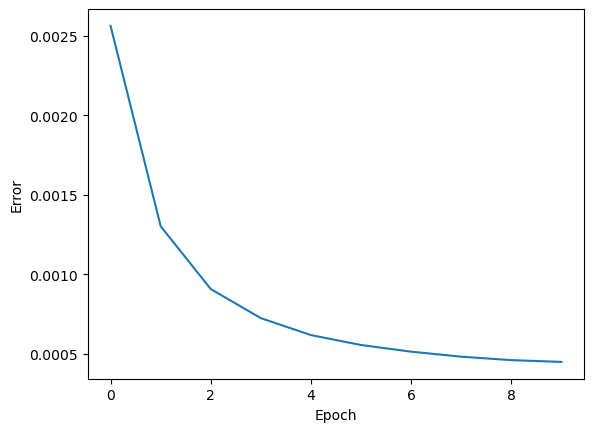

In [52]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [53]:
mock_user_id = 151

In [54]:
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# Feeding in the user and reconstructing the input. use sigmoid
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [56]:
scored_asin_df_mock = cleaned.drop_duplicates(subset=['ProductId'])
scored_asin_df_mock = scored_asin_df_mock.assign(RecommendationScore = rec[0])
scored_asin_df_mock[['ProductId','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(20)

,ProductId,RecommendationScore
4063,B001EW5YQS,0.025583
7321,B0042395CA,0.012464
45379,B000FVVZ3U,0.008445
40981,B000IKEGRK,0.005815
36090,B002DHN1UE,0.005210
17705,B0010AR1E2,0.004573
5012,B000HDKZDC,0.004495
17240,B000I6PZVK,0.004260
14515,B0016814QO,0.004161
33278,B001RQAVKK,0.004146


In [57]:
food_df_mock = cleaned[cleaned['UserID'] == 151]
food_df_mock.head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
151,B00374XSVY,Chris,5,Works with chicken fish beef or pork. Fast eas...,0,0,0.0,Positive,151
637,B000G6RYNE,Chris,4,"This kettle chips taste ""Good , Crispy & Crunc...",0,0,0.0,Positive,151
729,B008BEGP9W,Chris,4,I really like the pineapple shortcakes sold he...,0,0,0.0,Positive,151
1006,B002XG21MO,Chris,5,These are just like the animal crackers we eat...,0,0,0.0,Positive,151
3142,B000FDKQCY,Chris,5,This product is as good as any that I have eve...,0,0,0.0,Positive,151


In [58]:
merged_df_mock = scored_asin_df_mock.merge(food_df_mock, on='ProductId', how='outer')

In [59]:
merged_df_mock[['ProductId','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(5)

,ProductId,RecommendationScore
649,B001EW5YQS,0.025583
1122,B0042395CA,0.012464
5653,B000FVVZ3U,0.008445
5023,B000IKEGRK,0.005815
4366,B002DHN1UE,0.005210


Above are the top 5 items that Chris will be interested in purchasing for reviewing.

### Conclusion

#### In this project, I successfully conducted sentiment analysis on the Amazon Fine Food Reviews dataset using Jupyter Notebooks and various natural language processing techniques. Our main objective was to recommend new products to someone who does reviews often (Chris), using RNN to perform sentiment analysis using only Amazon reviews as the model. I began by performing exploratory data analysis to gain insights into the dataset's characteristics and distribution of sentiments. Preprocessing steps, such as removing stop words, were applied to clean the text data and enhance the quality of our sentiment analysis. This analysis provided valuable insights into the key factors driving positive or negative sentiment within the Amazon Fine Food Reviews dataset.
 
#### The Sentiment Analysis on Amazon Fine Food Reviews project successfully employed deep learning techniques to classify customer reviews as positive or negative. The outcome of this project contributes to a better understanding of customer sentiments and can be potentially applied in various industries for customer feedback analysis and decision-making processes. Overall, this project was a success.